In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import pickle
import random
import time
import itertools
from pathlib import Path

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from system import ATNNS

base_path = Path().resolve()

In [ ]:
#Load example data and ensure correct formatting for model input
df = pd.read_parquet(base_path / 'data' / 'eaim_example_data.parquet')

df_actual = df[['phase', 'amm_nit', 'amm_chl', 'water_content']].copy()
df = df.drop(['water_content', 'p_H2O', 'p_HNO3', 'p_HCl', 'p_NH3', 'p_H2SO4', 'amm_nit', 'amm_chl', 'phase'], axis=1)

df_actual.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,TEMP,RH,NH4+,NA+,SO42-,NO3-,CL-
0,263.15,0.6,0.0,1.0,0.0,0.0,1.0
1,263.15,0.6,0.0,1.0,0.0,1.0,0.0
2,263.15,0.6,0.0,2.0,0.0,1.0,1.0
3,263.15,0.6,0.0,2.0,1.0,0.0,0.0
4,263.15,0.6,0.0,3.0,0.0,1.0,2.0


In [ ]:
#Establish system solver
solver = ATNNS()
#Generate predictions
results = solver.prediction(df)

2500/2500 [==============================] - 1s 193us/step


In [59]:
results.sample(10)

,phase,amm_nit,amm_chl,water_content
666466,0,1.949289e-19,7.039623e-19,30.802385
2108582,0,8.530073e-18,1.680253e-17,57.427734
578378,1,0.000000e+00,0.000000e+00,0.000000
593875,0,9.910420e-21,1.784608e-19,80.738173
2749541,0,1.578128e-16,1.926804e-16,76.998801
1466659,0,9.105585e-22,7.798355e-22,15493.200073
2220407,0,3.863705e-17,1.710465e-17,71.603813
2104715,0,0.000000e+00,0.000000e+00,73.926819
1308281,0,7.625707e-19,3.378120e-18,106.298682
3174791,0,9.666458e-17,8.451327e-17,253.483730


In [56]:
metrics = solver.evaluate_results(df_actual.drop('phase',axis=1), results.drop('phase', axis=1), inputs=df)
metrics

{'amm_nit': {'mape': 0.023222552673571165,
  'nmae': 0.10803412531521368,
  'rmse': 4.658655295200931e-16},
 'amm_chl': {'mape': 0.022515875251830346,
  'nmae': 0.0683528308836218,
  'rmse': 7.255663724543403e-16},
 'water_content': {'mass_error': 0.04306630083346506,
  'mape': 0.1319499666269171,
  'nmae': 0.02582314274258602,
  'rmse': 99.51833988510808}}

In [57]:
print(classification_report(df_actual['phase'], results['phase']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3223483
           1       0.98      0.99      0.99    162099

    accuracy                           1.00   3385582
   macro avg       0.99      1.00      0.99   3385582
weighted avg       1.00      1.00      1.00   3385582



In [60]:
df_actual.rename(columns={'phase':'actual_phase', 'amm_nit':'actual_amm_nit', 'amm_chl':'actual_amm_chl', 'water_content':'actual_water_content'}, inplace=True)
comp = pd.concat([df, df_actual, results], axis=1)
comp.sample(10)

,TEMP,RH,NH4+,NA+,SO42-,NO3-,CL-,actual_phase,actual_amm_nit,actual_amm_chl,actual_water_content,phase,amm_nit,amm_chl,water_content
2284208,307.884,0.88429,4.0,5.0,1.0,0.0,7.0,0,0.000000e+00,5.739659e-17,131.4050,0,3.307859e-19,5.623798e-17,124.025465
2920515,319.445,0.88429,2.0,5.0,2.0,3.0,0.0,0,1.108947e-16,0.000000e+00,72.9541,0,1.112983e-16,6.262774e-18,70.939724
2673898,314.921,0.88429,1.0,8.0,1.0,6.0,1.0,0,2.024301e-17,7.511449e-18,114.6700,0,2.002288e-17,7.357685e-18,112.056730
255228,271.695,0.65686,9.0,4.0,2.0,8.0,1.0,0,3.143296e-20,2.721747e-20,22.0408,0,3.078440e-20,2.500937e-20,29.092426
2361356,309.392,0.71371,9.0,6.0,2.0,9.0,2.0,0,1.350937e-16,1.254313e-16,65.1550,0,1.326342e-16,1.232841e-16,63.071019
1828104,299.842,0.88429,5.0,7.0,1.0,6.0,4.0,0,2.604141e-18,4.042317e-18,156.3920,0,2.615141e-18,4.028788e-18,152.138735
2252102,307.382,0.82743,4.0,3.0,0.0,6.0,1.0,0,5.026212e-17,2.351760e-17,56.0964,0,4.980789e-17,2.261868e-17,57.154247
1905940,301.350,0.77057,3.0,10.0,1.0,2.0,9.0,0,1.584810e-18,2.732668e-17,103.8960,0,1.609528e-18,2.675447e-17,97.412618
782806,281.747,0.65686,1.0,10.0,0.0,4.0,7.0,0,8.300328e-20,4.749841e-19,18.4070,0,7.824545e-20,4.037585e-19,51.730254
1734832,298.334,0.77057,1.0,8.0,0.0,3.0,6.0,0,7.402524e-19,5.974775e-18,73.9905,0,7.439722e-19,6.032258e-18,68.580993


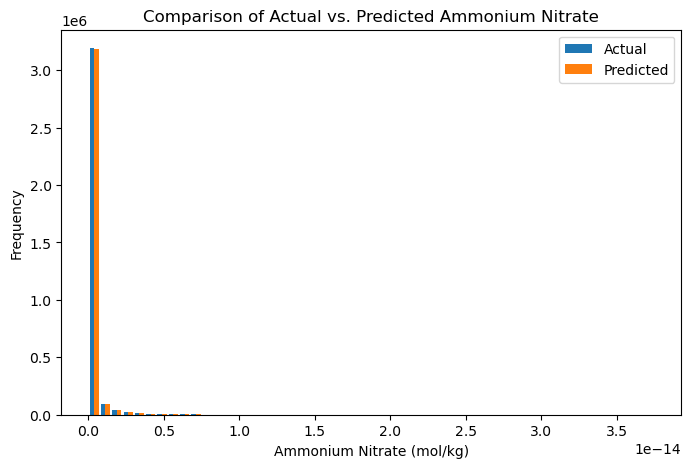

In [61]:

with open(base_path / 'models' / 'solid_amm_nit_nonzero.pkl', 'rb') as file:
    load_model = pickle.load(file)
b = load_model.coef_[0]
a = np.exp(load_model.intercept_)

results['amm_nit_test'] = results['amm_nit']/(a * np.exp(b * (1/df['TEMP'])))
df_actual['amm_nit_test'] = df_actual['actual_amm_nit']/(a * np.exp(b * (1/df['TEMP'])))

plt.figure(figsize=(8, 5))
plt.hist([df_actual['actual_amm_nit'], results['amm_nit']], bins=50, label=['Actual', 'Predicted'])
plt.xlabel('Ammonium Nitrate (mol/kg)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Comparison of Actual vs. Predicted Ammonium Nitrate')
plt.show()

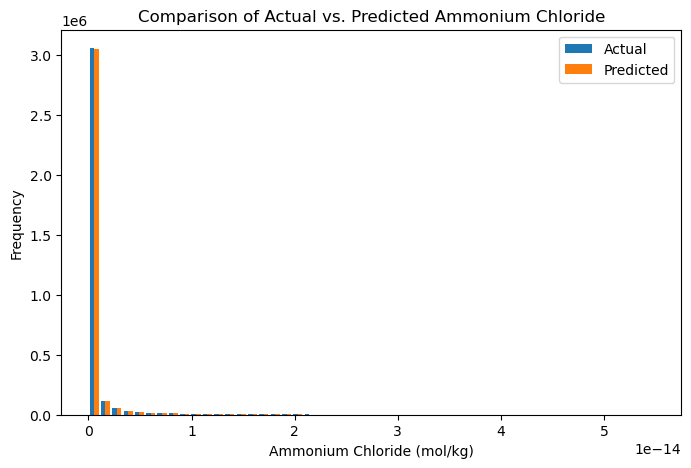

In [62]:

with open(base_path / 'models' / 'solid_amm_chl_nonzero.pkl', 'rb') as file:
    load_model = pickle.load(file)
b = load_model.coef_[0]
a = np.exp(load_model.intercept_)

results['amm_chl_test'] = results['amm_chl']/(a * np.exp(b * (1/df['TEMP'])))
df_actual['amm_chl_test'] = df_actual['actual_amm_chl']/(a * np.exp(b * (1/df['TEMP'])))

plt.figure(figsize=(8, 5))
plt.hist([df_actual['actual_amm_chl'], results['amm_chl']], bins=50, label=['Actual', 'Predicted'])
plt.xlabel('Ammonium Chloride (mol/kg)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Comparison of Actual vs. Predicted Ammonium Chloride')
plt.show()

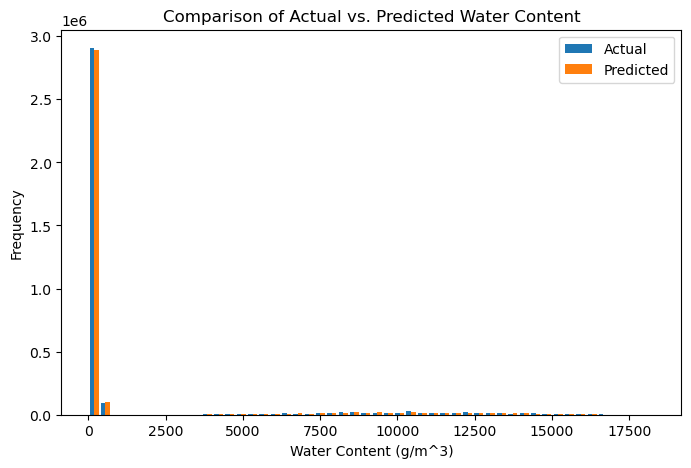

In [63]:
plt.figure(figsize=(8, 5))
plt.hist([df_actual['actual_water_content'], results['water_content']], bins=50, label=['Actual', 'Predicted'])
plt.xlabel('Water Content (g/m^3)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Comparison of Actual vs. Predicted Water Content')
plt.show()